In [6]:
#coding=utf-8
from keras.models import Model
from keras.layers import Input,Dense,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,ZeroPadding2D,concatenate,Dropout
from keras.layers import add,Flatten
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
import matplotlib.pyplot as plt
import keras
import datetime
import keras
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout,DepthwiseConv2D
from keras.layers import Activation, BatchNormalization, add, Reshape,ReLU
#from keras.applications.mobilenet import relu6, DepthwiseConv2D
from keras.applications import MobileNet
from keras.utils.vis_utils import plot_model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


starttime = datetime.datetime.now()
def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    x = keras.layers.ReLU(6.)(x)
    return x
    #return Activation(relu6)(x)


def _bottleneck(inputs, filters, kernel, t, s, r=False):#2x2的_bottleneck
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    tchannel = K.int_shape(inputs)[channel_axis] * t

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = keras.layers.ReLU(6.)(x)
    #添加2x2
    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = keras.layers.ReLU(6.)(x)
    #x = Activation(relu6)(x)

    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)

    if r:
        x = add([x, inputs])
    return x


def _inverted_residual_block(inputs, filters, kernel, t, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs, filters, kernel, t, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, 1, True)

    return x

inputs = Input(shape=(224,224,3))
# x = Lambda(lambda x:x[:,78:178,78:178,:])(inpt)

x = _conv_block(inputs, 32, (3, 3), strides=(2, 2))

x = _inverted_residual_block(x, 16, (2, 2), t=1, strides=1, n=1)
x = _inverted_residual_block(x, 24, (2, 2), t=6, strides=2, n=2)
x = _inverted_residual_block(x, 32, (2, 2), t=6, strides=2, n=3)
#x = _inverted_residual_block(x, 64, (2, 2), t=6, strides=2, n=4)
x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
#2
x = Conv2D(64, (3, 3),strides=(1, 1),padding='same', activation='relu',kernel_initializer='uniform')(x)
x = BatchNormalization(name='bn_conv1')(x)
x = Conv2D(64, (3, 3),strides=(1, 1),padding='same', activation='relu',kernel_initializer='uniform')(x)
x = BatchNormalization(name='bn_conv2')(x)
x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)
#3
x = Conv2D(128, (3, 3),strides=(1, 1),padding='same', activation='relu',kernel_initializer='uniform')(x)
x = BatchNormalization(name='bn_conv3')(x)
x = Conv2D(128, (3, 3),strides=(1, 1),padding='same', activation='relu',kernel_initializer='uniform')(x)
x = BatchNormalization(name='bn_conv4')(x)
x = Conv2D(128, (3, 3),strides=(1, 1),padding='same', activation='relu',kernel_initializer='uniform')(x)
x = BatchNormalization(name='bn_conv5')(x)
x = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)

x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
#x = Dense(512,activation='relu')(x)
#x = keras.layers.Dropout(0.5)(x)
x = Dense(4,activation='softmax')(x)
model = Model(inputs=inputs,outputs=x)
model.summary()

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=optimizers.sgd(lr=0.05,momentum=0.9,decay=0.0002,nesterov=True),
              metrics=['accuracy'])
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)
train_dir = '/home/tx-lab/RongShanshan/article2/Dataset03/Segtrain'
validation_dir = '/home/tx-lab/RongShanshan/article2/Dataset03/Segvalid'
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=48,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=48,
        class_mode='categorical')

MC = keras.callbacks.ModelCheckpoint(filepath='/home/tx-lab/RongShanshan/article2/models3/VGG16_mobilinetV2_Seg.h5',monitor='val_accuracy',
                                                        verbose=1,
                                                        save_best_only=True,
                                                        save_weights_only=False,
                                                        mode='auto',
                                                        period=1)
RL = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                    factor=0.1,
                                                    patience=10,
                                                    verbose=1,
                                                    mode='auto',
                                                    min_delta=0.000001,
                                                    cooldown=0,
                                                    min_lr=0 )


history = model.fit_generator(
      train_generator,
      steps_per_epoch=None,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=None,
      callbacks=[MC,RL])

model.save('/home/tx-lab/RongShanshan/article2/models3/VGG16_mobilinetV2_Seg.h5')
with open('/home/tx-lab/RongShanshan/article2/models3/VGG16_mobilinetV2_Seg.txt','w') as f:
    f.write(str(history.history))

endtime = datetime.datetime.now()
print( (endtime - starttime).seconds)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 112, 112, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_158 (BatchN (None, 112, 112, 32) 128         conv2d_114[0][0]                 
__________________________________________________________________________________________________
re_lu_120 (ReLU)                (None, 112, 112, 32) 0           batch_normalization_158[0][0]    
____________________________________________________________________________________________

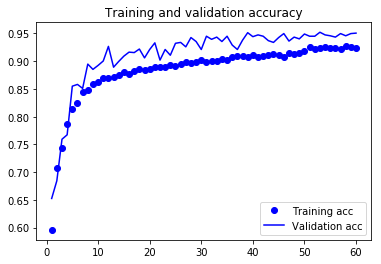

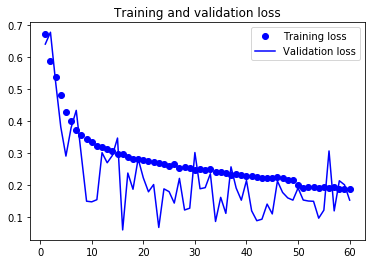

In [2]:


model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=optimizers.sgd(lr=0.05,momentum=0.9,decay=0.0002,nesterov=True),
              metrics=['accuracy'])
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)
train_dir = '/home/tx-lab/RongShanshan/article2/Dataset03/Segtrain'
validation_dir = '/home/tx-lab/RongShanshan/article2/Dataset03/Segvalid'
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=48,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=48,
        class_mode='categorical')

MC = keras.callbacks.ModelCheckpoint(filepath='/home/tx-lab/RongShanshan/article2/models3/VGG16_mobilinetV2_Seg.h5',monitor='val_accuracy',
                                                        verbose=1,
                                                        save_best_only=True,
                                                        save_weights_only=False,
                                                        mode='auto',
                                                        period=1)
RL = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                    factor=0.1,
                                                    patience=10,
                                                    verbose=1,
                                                    mode='auto',
                                                    min_delta=0.000001,
                                                    cooldown=0,
                                                    min_lr=0 )


history = model.fit_generator(
      train_generator,
      steps_per_epoch=None,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=None,
      callbacks=[MC,RL])

model.save('/home/tx-lab/RongShanshan/article2/models3/VGG16_mobilinetV2_Seg.h5')
with open('/home/tx-lab/RongShanshan/article2/models3/VGG16_mobilinetV2_Seg.txt','w') as f:
    f.write(str(history.history))

endtime = datetime.datetime.now()
print( (endtime - starttime).seconds)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()